# Nuclie Semantic Segmentation - UNet using Tensorflow 2

# Intro
- Dataset used is from Kaggle's Data Science Bowl 2018 - Nuclei Segmentation
- The architecture used is [U-Net](https://arxiv.org/abs/1505.04597), which is very common for image segmentation problems such as this.
- This notebook is inspired from the great kernel [Keras U-net starter - LB 0.277](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277) by Kjetil Åmdal-Sævik.

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers import concatenate
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
TRAIN_PATH = 'dataset/stage1_train/'
TEST_PATH = 'dataset/stage1_test/'

dir_path = ''

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [5]:
os.getcwd()

'/Users/cusniwtt/Documents/GitHub/unet-nucleus'

In [6]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get the data
- Downsample both the training and test images to reduce computations
- Retain record of the original sizes of the test images to upsample predicted masks and create correct run-length encodings 

In [7]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    
    #Read image files iteratively
    path = TRAIN_PATH + id_
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Append image to numpy array for train dataset
    X_train[n] = img
    
    #Read corresponding mask files iteratively
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    
    #Looping through masks
    for mask_file in next(os.walk(path + '/masks/'))[2]:

        # Remove .DS_Store file
        if mask_file == '.DS_Store':
            continue
        
        #Read individual masks
        mask_ = imread(dir_path + path + '/masks/' + mask_file)
        
        #Expand individual mask dimensions
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)

        #Overlay individual masks to create a final mask for corresponding image
        try:
            mask = np.maximum(mask, mask_)
        except:
            print(mask_file)
    
    #Append mask to numpy array for train dataset
    Y_train[n] = mask


# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    
    #Read images iteratively
    img = imread(dir_path + path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    
    #Get test size
    sizes_test.append([img.shape[0], img.shape[1]])
    
    #Resize image to match training data
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #Append image to numpy array for test dataset
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 100/100 [00:19<00:00,  5.04it/s]

Getting and resizing test images ... 



100%|██████████| 12/12 [00:00<00:00, 22.63it/s]

Done!


## Visualize imported data

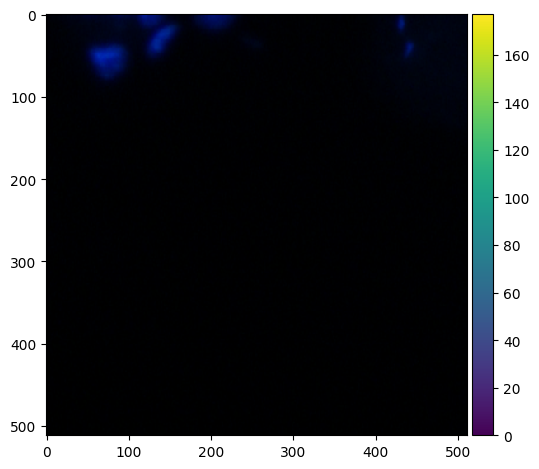

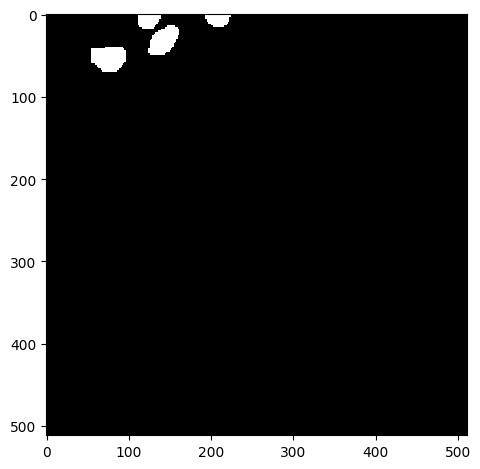

In [8]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

## Data Augmentation

In [9]:
import albumentations as A
import cv2

transform = A.Compose([
    A.Resize(width=512, height=512),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.CLAHE(p=0.5),
])
rounds = 10
X_train_aug = np.zeros((0, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train_aug = np.zeros((0, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
print('Augmentation train images and masks ... ')
for r in range(rounds):
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        X_img = X_train[n]
        Y_img = Y_train[n]*1
        augmented = transform(image=X_img, mask=Y_img.astype(np.uint8))
        if not np.any(augmented['mask']):
            continue
        else:
            X_train_aug = np.append(X_train_aug, augmented['image'].reshape(1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), axis=0)
            Y_train_aug = np.append(Y_train_aug, augmented['mask'].astype(bool).reshape(1, IMG_HEIGHT, IMG_WIDTH, 1), axis=0)

Augmentation train images and masks ... 


100%|██████████| 100/100 [00:13<00:00,  7.55it/s]


In [10]:
print(X_train_aug.shape)
print(Y_train_aug.shape)

(994, 512, 512, 3)
(994, 512, 512, 1)


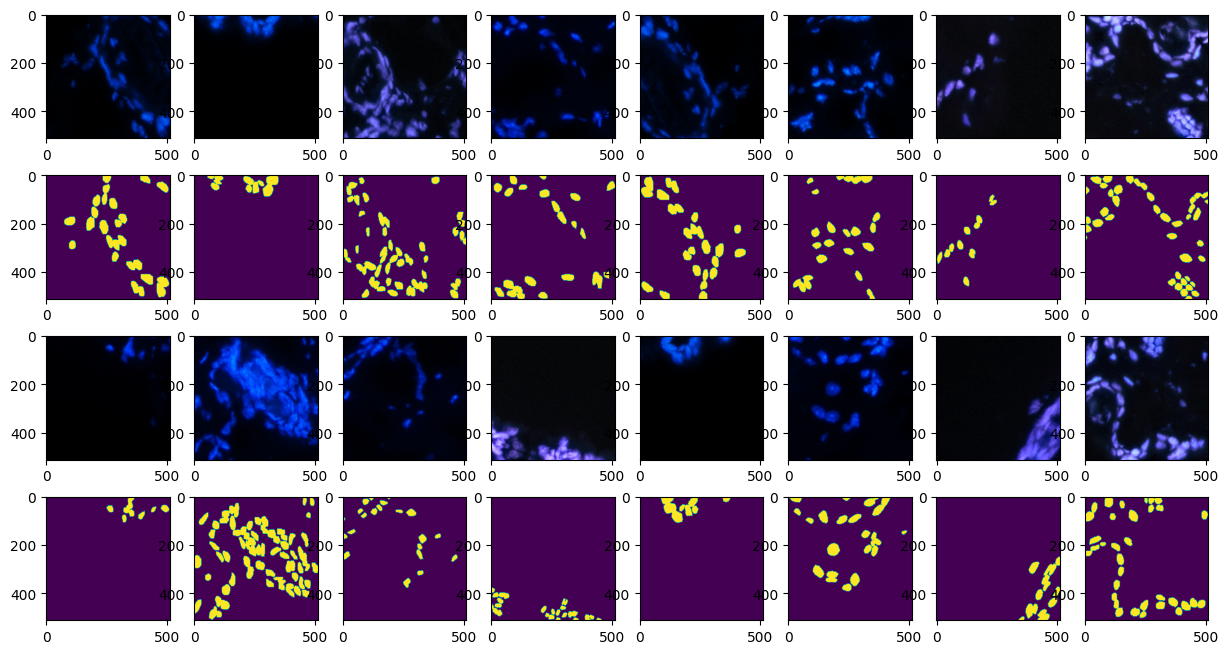

In [11]:
# Check if training data looks all right
X_train = X_train_aug
Y_train = Y_train_aug

ix = random.sample(range(0, X_train.shape[0]), 16)
fig, axs = plt.subplots(4, 8, figsize=(15, 8))
row = 0
col = 0
for i in ix:
  axs[row][col].imshow(X_train[i])
  axs[row+1][col].imshow(np.squeeze(Y_train[i]))
  col = col + 1
  if col == 8:
    col = 0
    row = row + 2

plt.show()

# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" alt="UNet" style="height: 400px; width:600px;"/>

## U-Net baseline

In [10]:
# Build U-Net model

def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = BatchNormalization()(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = BatchNormalization()(c)
    p = MaxPooling2D((2, 2), (2, 2))(c)
    p = Dropout(dropout)(p)
    return c, p

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.3):
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = BatchNormalization()(c)
    c = Dropout(dropout)(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = BatchNormalization()(c)
    return c

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2):
    us = UpSampling2D((2, 2))(x)
    concat = concatenate([us, skip])
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = BatchNormalization()(c)
    c = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    c = BatchNormalization()(c)
    c = Dropout(dropout)(c)
    return c

def unet_model(filters=64, input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), nn_name="unet"):
    inputs = Input(input)
    s = Lambda(lambda x: x / 255)(inputs)
    down1 = down_block(s, filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.1)
    down2 = down_block(down1[1], filters*2, kernel_size=(3, 3), padding="same", strides=1, dropout=0.1)
    down3 = down_block(down2[1], filters*4, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2)
    down4 = down_block(down3[1], filters*8, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2)
    bottleneck1 = bottleneck(down4[1], filters*16, kernel_size=(3, 3), padding="same", strides=1, dropout=0.3)
    up1 = up_block(bottleneck1, down4[0], filters*8, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2)
    up2 = up_block(up1, down3[0], filters*4, kernel_size=(3, 3), padding="same", strides=1, dropout=0.2)
    up3 = up_block(up2, down2[0], filters*2, kernel_size=(3, 3), padding="same", strides=1, dropout=0.1)
    up4 = up_block(up3, down1[0], filters, kernel_size=(3, 3), padding="same", strides=1, dropout=0.1)
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(up4)
    model = Model(inputs=[inputs], outputs=[outputs], name=nn_name)
    return model

### Optimizer Loss Metrics

In [11]:
# Optimizer
from keras import optimizers
sgd = optimizers.SGD(learning_rate=0.002, decay=0.00003, momentum=0.9)
adam = optimizers.Adam(learning_rate=0.002, decay=0.00003)

# Loss function
from keras.losses import BinaryCrossentropy
bce = BinaryCrossentropy()

# Metrics
from keras.metrics import Recall, Precision, BinaryIoU
recall = Recall()
precision = Precision()

# Fit model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
earlystopper = EarlyStopping(patience=15, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=4, min_lr=0.00001, verbose=1)

In [12]:
model_repr = unet_model(filters=32, input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model_repr.summary()
del(model_repr)

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['lambda[0][0]']                 
                                )                                                                 
                                                                                               

### Train model

In [15]:
# Adam, BCE, batch_size=8
model = unet_model(filters=32, input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), nn_name='unet_32_adam_bce_8')
print('##################################')
print('     Adam, BCE, batch_size=8      ')
print('##################################')
model.compile(optimizer=adam, loss=bce, metrics=[recall, precision],)
checkpointer = ModelCheckpoint('weights/unet_checkpoint_32_adam_bce_8.h5', verbose=1, save_best_only=True)
results_adam_bce_8 = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=100, 
                    callbacks=[earlystopper, checkpointer, reduce_lr], verbose=1, shuffle=True)
K.clear_session()
del(model)

##################################
     Adam, BCE, batch_size=8      
##################################
Epoch 1/100
112/112 [==============================] - ETA: 0s - loss: 0.3063 - recall: 0.7676 - precision: 0.5684
Epoch 1: val_loss improved from inf to 24.23730, saving model to weights/unet_checkpoint_32_adam_bce_8.h5
112/112 [==============================] - 118s 1s/step - loss: 0.3063 - recall: 0.7676 - precision: 0.5684 - val_loss: 24.2373 - val_recall: 0.9570 - val_precision: 0.0724 - lr: 0.0020
Epoch 2/100
112/112 [==============================] - ETA: 0s - loss: 0.1216 - recall: 0.6766 - precision: 0.7237
Epoch 2: val_loss improved from 24.23730 to 0.23962, saving model to weights/unet_checkpoint_32_adam_bce_8.h5
112/112 [==============================] - 114s 1s/step - loss: 0.1216 - recall: 0.6766 - precision: 0.7237 - val_loss: 0.2396 - val_recall: 0.0728 - val_precision: 0.9317 - lr: 0.0020
Epoch 3/100
112/112 [==============================] - ETA: 0s - loss: 0.0982 

In [13]:
# SGD, BCE, batch_size=8
model = unet_model(filters=32, input=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), nn_name='unet_32_adam_bce_8')
print('##################################')
print('     SGD, BCE, batch_size=8       ')
print('##################################')
model.compile(optimizer=sgd, loss=bce, metrics=[recall, precision])
checkpointer = ModelCheckpoint('weights/unet_checkpoint_32_sgd_bce_8.h5', verbose=1, save_best_only=True)
results_sgd_bce_8 = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=100,
                    callbacks=[earlystopper, checkpointer, reduce_lr], verbose=1, shuffle=True)
K.clear_session()
del(model)

##################################
     SGD, BCE, batch_size=8       
##################################
Epoch 1/100
112/112 [==============================] - ETA: 0s - loss: 0.4099 - recall: 0.8027 - precision: 0.3668
Epoch 1: val_loss improved from inf to 0.27476, saving model to weights/unet_checkpoint_32_sgd_bce_8.h5
112/112 [==============================] - 141s 1s/step - loss: 0.4099 - recall: 0.8027 - precision: 0.3668 - val_loss: 0.2748 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 0.0020
Epoch 2/100
112/112 [==============================] - ETA: 0s - loss: 0.1911 - recall: 0.6842 - precision: 0.6663
Epoch 2: val_loss improved from 0.27476 to 0.22820, saving model to weights/unet_checkpoint_32_sgd_bce_8.h5
112/112 [==============================] - 113s 1s/step - loss: 0.1911 - recall: 0.6842 - precision: 0.6663 - val_loss: 0.2282 - val_recall: 1.6335e-04 - val_precision: 1.0000 - lr: 0.0020
Epoch 3/100
112/112 [==============================] - ETA: 0s - loss: 

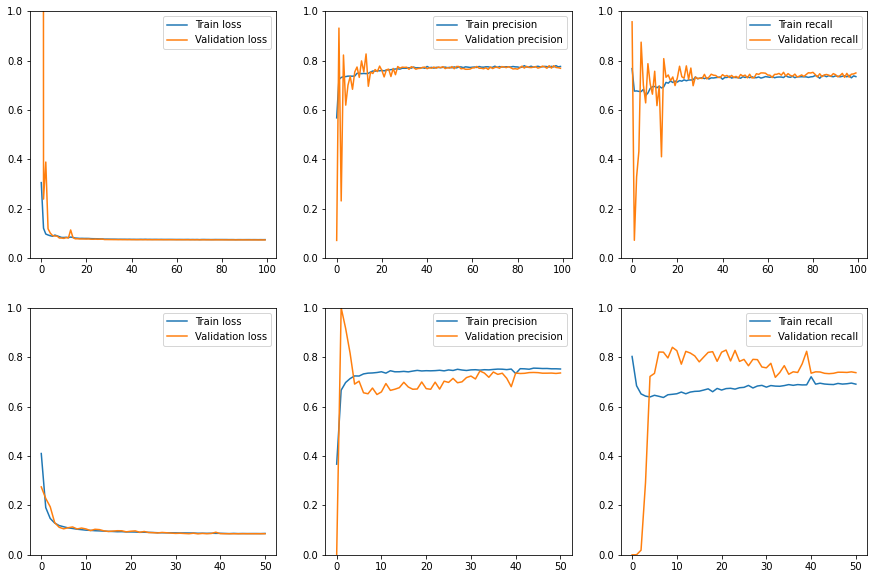

In [19]:
test_list = [results_adam_bce_8, results_sgd_bce_8,]
row = 0
fig, axs = plt.subplots(len(test_list), 3, figsize=(15,10))
for test in test_list:
    axs[row][0].plot(test.epoch, test.history["loss"], label="Train loss")
    axs[row][0].plot(test.epoch, test.history["val_loss"], label="Validation loss")
    axs[row][1].plot(test.epoch, test.history["precision"], label="Train precision")
    axs[row][1].plot(test.epoch, test.history["val_precision"], label="Validation precision")
    axs[row][2].plot(test.epoch, test.history["recall"], label="Train recall")
    axs[row][2].plot(test.epoch, test.history["val_recall"], label="Validation recall")

    axs[row][0].legend()
    axs[row][1].legend()
    axs[row][2].legend()

    axs[row][0].set_ylim(0, 1)
    axs[row][1].set_ylim(0, 1)
    axs[row][2].set_ylim(0, 1)

    row += 1


# Make predictions

In [ ]:
def prediction(model_path, X_train, X_test, thres = 0.5):
  # Predict on train, val and test
  model = load_model(model_path)
  preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
  preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
  preds_test = model.predict(X_test, verbose=1)

  # Threshold predictions
  preds_train_t = (preds_train > thres).astype(np.uint8)
  preds_val_t = (preds_val > thres).astype(np.uint8)
  preds_test_t = (preds_test > thres).astype(np.uint8)

  # Create list of upsampled test masks
  preds_list = [preds_train_t, preds_val_t, preds_test_t]
  preds_train_upsampled = []
  preds_val_upsampled = []
  preds_test_upsampled = []
  for preds in preds_list:
    for i in range(len(preds)):
      preserve = np.squeeze(preds[i])
      res = resize(preserve, (sizes_test[i][0], sizes_test[i][1]), mode='constant', preserve_range=True)
      preds_test_upsampled.append(res)
    return preds_test_upsampled

In [ ]:
adam_bce = prediction('weights/unet_checkpoint_32_adam_bce_8.h5', X_train, X_test)
sgd_bce = prediction('weights/unet_checkpoint_32_sgd_bce_8.h5', X_train, X_test)

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



: 

: 

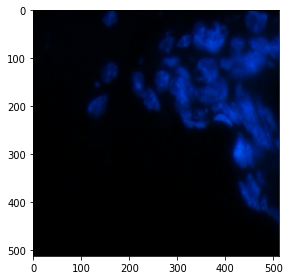

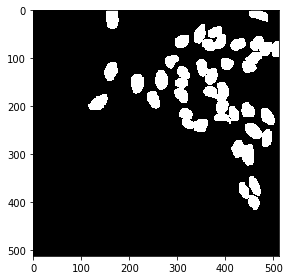

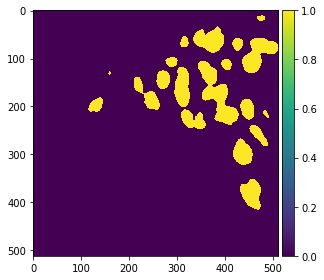

In [32]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_test_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

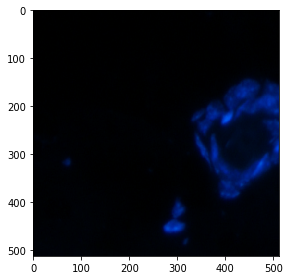

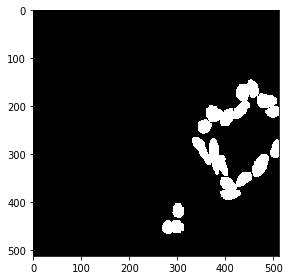

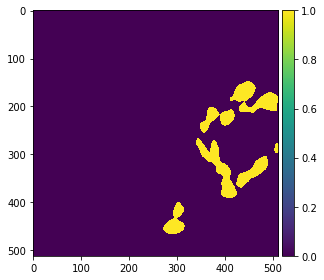

In [33]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

# Encode and submit our results

- [Link](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) has an excellent implementation of run-length encoding.

In [ ]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

- Iterate over the test IDs and generate run-length encodings for each seperate mask identified by skimage ...

In [ ]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

- Create submission

In [ ]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)

## U-Net Sequential
inputs = Input(input)
s = Lambda(lambda x: x / 255)(inputs)
c1 = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(filters*3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(filters*3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(filters*5, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(filters*5, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(filters*3, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(filters*2, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(filters*3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(filters*3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(filters/2, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization()(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)